In [3]:
import pandas as pd
import numpy as np
import re
import codecs
import csv
import matplotlib.pyplot as plt

# NLTK
import nltk
from nltk.stem import WordNetLemmatizer

# Gensim
import gensim
from gensim.models import KeyedVectors
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import concatenate
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Overbodig?
#from sklearn.model_selection import train_test_split
#from nltk.stem import PorterStemmer
#from nltk.stem import LancasterStemmer
#from nltk.tokenize import sent_tokenize, word_tokenize
#from nltk.corpus import brown

In [2]:
# Eenmalig downloaden
#nltk.download('punkt')
#nltk.download('wordnet')
#nltk.download('brown')

# Prevent unhelpful warnings
pd.options.mode.chained_assignment = None

In [4]:
# Function for cleaning the sentences and lemmatizing them
"""
"Lemmatization, unlike Stemming, reduces the inflected words properly ensuring that the root word belongs to the language."
Lemmatization is waarschijnlijk beter dan stemming in ons project omdat de betekenis van de woorden erg belangrijk is 
"""

def cleanSentence(text):
    
    # clean the text
    text = str(text).lower()
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e ?-? ?mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    
    # tokenize
    words=text.split()
    
    # lemmatize
    wordnet_lemmatizer = WordNetLemmatizer()
    lem_sentence=[]
    for word in words:   
        lem_sentence.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
        lem_sentence.append(" ")
    
    return "".join(lem_sentence)

In [4]:
# Apply function to the train data

train_data = pd.read_csv('train_data.csv')

train_data['q1_clean'] = train_data['question1'].apply(cleanSentence)
train_data['q2_clean'] = train_data['question2'].apply(cleanSentence)


In [5]:
# Apply function to the test data

test_data = pd.read_csv('test_data.csv')

test_data['q1_clean'] = test_data['question1'].apply(cleanSentence)
test_data['q2_clean'] = test_data['question2'].apply(cleanSentence)

#### Word index

In [6]:
# The Tokenizer stores everything in the word_index during fit_on_texts
tokenizer = Tokenizer(num_words=200000)

# Omzitten naar list om alle woorden in de fit_on_texts functie te krijgen
train_data_q1 = train_data['q1_clean'].tolist()
train_data_q2 = train_data['q2_clean'].tolist()
test_data_q1 = test_data['q1_clean'].tolist()
test_data_q2 = test_data['q2_clean'].tolist()

tokenizer.fit_on_texts(train_data_q1+
                       train_data_q2+
                       test_data_q1+
                       test_data_q2)

word_index = tokenizer.word_index
print('%s unique words' % len(word_index))

77325 unique words


#### Embedding matrix

In [7]:
# Location of the embedding file
EMB_FILE = 'C:/Renee/aml2018/GoogleNews-vectors-negative300.bin'

word2vec = KeyedVectors.load_word2vec_format(EMB_FILE, binary=True)
print('%s word vectors' % len(word2vec.vocab))


3000000 word vectors


In [8]:
MAX_WORDS = 250000
EMB_DIM = 300

In [9]:
# Embedding matrix maken (300 dimension vectoren voor alle woorden uit de index)
n_words = min(MAX_WORDS, len(word_index))+1

embedding_matrix = np.zeros((n_words, EMB_DIM))
for word, i in word_index.items():
    if word in word2vec.vocab:
        embedding_matrix[i] = word2vec.word_vec(word)
        
print('Words without embedding: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

Words without embedding: 37254


In [10]:
embedding_matrix.shape

(77326, 300)

#### Sequences

In [11]:
LENGTH_SEQUENCE = 35

In [12]:
# Train data to sequences

train_seq_1 = tokenizer.texts_to_sequences(train_data['q1_clean'])
train_seq_2 = tokenizer.texts_to_sequences(train_data['q2_clean'])

# Padding in sequences when sentences smaller than 25 words
train_data_1 = pad_sequences(train_seq_1, maxlen=LENGTH_SEQUENCE)
train_data_2 = pad_sequences(train_seq_2, maxlen=LENGTH_SEQUENCE)

print('Shape of tensor:', train_data_1.shape)

Shape of tensor: (404290, 35)


In [13]:
# Test data to sequences

test_seq_1 = tokenizer.texts_to_sequences(test_data['q1_clean'])
test_seq_2 = tokenizer.texts_to_sequences(test_data['q2_clean'])

# Padding in sequences when sentences smaller than 25 words
test_data_1 = pad_sequences(test_seq_1, maxlen=LENGTH_SEQUENCE)
test_data_2 = pad_sequences(test_seq_2, maxlen=LENGTH_SEQUENCE)

print('Shape of tensor:', test_data_1.shape)

Shape of tensor: (81126, 35)


#### Labels

In [14]:
# Labels naar numpy array
labels = train_data['is_duplicate']
labels = labels.as_matrix()

print('Shape of label tensor:', labels.shape)

Shape of label tensor: (404290,)


C:\Renee\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


#### Validation split

In [15]:
SPLIT = 0.1

In [16]:
# Make a validation split of 10%

# Index van train en validation set
p = np.random.permutation(len(train_data_1))
train_index = p[:int(len(train_data_1)*(1-SPLIT))]
val_index = p[int(len(train_data_1)*(1-SPLIT)):]

# train set
train_1 = np.vstack((train_data_1[train_index], train_data_2[train_index]))
train_2 = np.vstack((train_data_2[train_index], train_data_1[train_index]))

# validation set
val_1 = np.vstack((train_data_1[val_index], train_data_2[val_index]))
val_2 = np.vstack((train_data_2[val_index], train_data_1[val_index]))

# Inclusief labels
train_lab = np.concatenate((labels[train_index], labels[train_index]))
val_lab = np.concatenate((labels[val_index], labels[val_index]))

# Weights
val_weight = np.ones(len(val_lab))

In [17]:
print('Shape of training data tensor:', train_1.shape)
print('Shape of validation data tensor:', val_1.shape)

Shape of train tensor: (727722, 35)
Shape of validation tensor: (80858, 35)


#### Model structure

In [ ]:
lstm_out = 200
lstm_drop_out = 0.2
dense_drop_out = 0.2
dense_out = 120
class_weight = None

In [18]:
embedding_layer = Embedding(n_words, EMB_DIM, weights=[embedding_matrix], input_length=LENGTH_SEQUENCE, trainable=False)
lstm_layer = LSTM(lstm_out, dropout=lstm_drop_out, recurrent_dropout=lstm_drop_out)

input_1 = Input(shape=(LENGTH_SEQUENCE,), dtype='int32')
embedded_sequences_1 = embedding_layer(input_1)
lstm_1 = lstm_layer(embedded_sequences_1)

input_2 = Input(shape=(LENGTH_SEQUENCE,), dtype='int32')
embedded_sequences_2 = embedding_layer(input_2)
lstm_2 = lstm_layer(embedded_sequences_2)

added = concatenate([lstm_1, lstm_2])
added = Dropout(dense_drop_out)(added)
added = BatchNormalization()(added)

added = Dense(dense_out, activation='relu')(added)
added = Dropout(dense_drop_out)(added)
added = BatchNormalization()(added)

prediction = Dense(1, activation='sigmoid')(added)

In [19]:
model = Model(inputs=[input_1, input_2], outputs=prediction)
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['acc'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 35, 300)      23197800    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 200)          400800      embedding_1[0][0]                
          

#### Train model

In [20]:
name= "model_5"

early_stopping =EarlyStopping(monitor='val_loss', patience=3)
bst_model_path = name + '.h5'
model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)

history = model.fit([train_1, train_2], train_lab, \
       validation_data=([val_1, val_2], val_lab, val_weight), \
       epochs=8, batch_size=2048, shuffle=True, \
       class_weight=class_weight, callbacks=[early_stopping, model_checkpoint])

model.load_weights(bst_model_path)
bst_val_score = min(history.history['val_loss'])


Train on 727722 samples, validate on 80858 samples
Epoch 1/8
727722/727722 [==============================] - 2236s 3ms/step - loss: 0.5302 - acc: 0.7288 - val_loss: 0.4746 - val_acc: 0.7662
Epoch 2/8
727722/727722 [==============================] - 2058s 3ms/step - loss: 0.4602 - acc: 0.7742 - val_loss: 0.4455 - val_acc: 0.7853
Epoch 3/8
727722/727722 [==============================] - 2062s 3ms/step - loss: 0.4295 - acc: 0.7925 - val_loss: 0.4121 - val_acc: 0.8020
Epoch 4/8
727722/727722 [==============================] - 2045s 3ms/step - loss: 0.4054 - acc: 0.8066 - val_loss: 0.3975 - val_acc: 0.8112
Epoch 5/8
727722/727722 [==============================] - 2024s 3ms/step - loss: 0.3876 - acc: 0.8174 - val_loss: 0.3826 - val_acc: 0.8191
Epoch 6/8
727722/727722 [==============================] - 2041s 3ms/step - loss: 0.3727 - acc: 0.8257 - val_loss: 0.3719 - val_acc: 0.8289
Epoch 7/8
727722/727722 [==============================] - 2020s 3ms/step - loss: 0.3595 - acc: 0.8329 - val_

#### Graphs to see progress

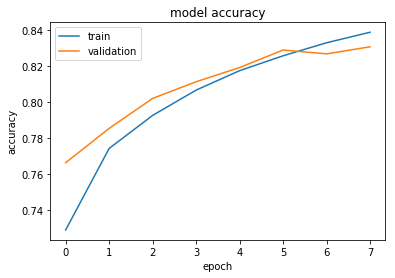

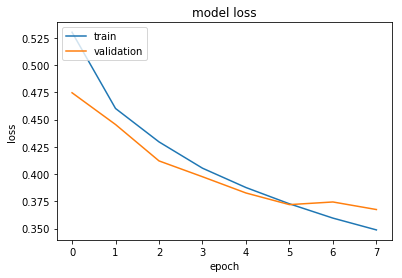

In [21]:
# Accuracy plot
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

#### Submission

In [22]:
test_ids = test_data['test_id']

In [23]:
predict = model.predict([test_data_1, test_data_2], batch_size=8192, verbose=1)
predict += model.predict([test_data_2, test_data_1], batch_size=8192, verbose=1)

81126/81126 [==============================] - 89s 1ms/step


In [24]:
predict = predict/2
predict = np.round(predict, 0)

submit = pd.DataFrame({'test_id':test_ids, 'is_duplicate':predict.ravel()})
submit.to_csv(name+'.csv', index=False)